## 1. Importing the dataset

In [1]:
import numpy as np
import pandas as pd
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings

warnings.filterwarnings('ignore')

c:\Users\Mo\work\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_columns', 50)
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sample_submission = pd.read_csv('sample_submission.csv')
print(f'''
Training set info:\n{df_train.info()}
Test set info:\n{df_test.info()}
Training set shape: {df_train.shape}  
Test set shape: {df_test.shape} 
''')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [3]:
df_train.head(1)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0


## 2. Data preprocessing

### 2.1 Distribuation of categorical and continuous data

In [4]:
# Let's split the features into continuous and categorical
continuous_columns = [key for key in df_train.keys() if df_train[key].dtype in ("int64", "float64")]
categorical_columns = [key for key in df_train.keys() if df_train[key].dtype == "object"]
categorical_columns.remove('Policy Start Date') # Need to be transformed later
print(f"Continuous : {len(continuous_columns)}, Categorical : {len(categorical_columns)}")
print(f"""
Continuous  features: {continuous_columns},\n
Categorical features: {categorical_columns}
      """)

Continuous : 10, Categorical : 10

Continuous  features: ['id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Premium Amount'],

Categorical features: ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']
      


Our target varible is **Premium Amount** and it is a continuous feature. This task is a regression task meaning based on all the other feature we want to predict the how much will the PRemium Amount be paid. 

In [5]:
print(f'''
NaN values in each feature and target varible.\n
Training set:\n
{df_train.isna().sum()}      
================================================
Test set:\n
{df_test.isna().sum()}      
''')


NaN values in each feature and target varible.

Training set:

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64      
Test set:

id                           0
Age                      12489
Gender                       0
Annual Income            29860
Marital Status           12336
Number of Dependents     73130
Education Level              0
Occupation              239125
Health 

Since I am using tree based models that can nativly handle NaN values I will leave them. Also thanks to insights from Chris Deotte, who observed the following: "NaN values are strongly correlated with the target, Premium Amount. This means that NAN contains additional information and we do not want to impute it and hide NANs from our models."


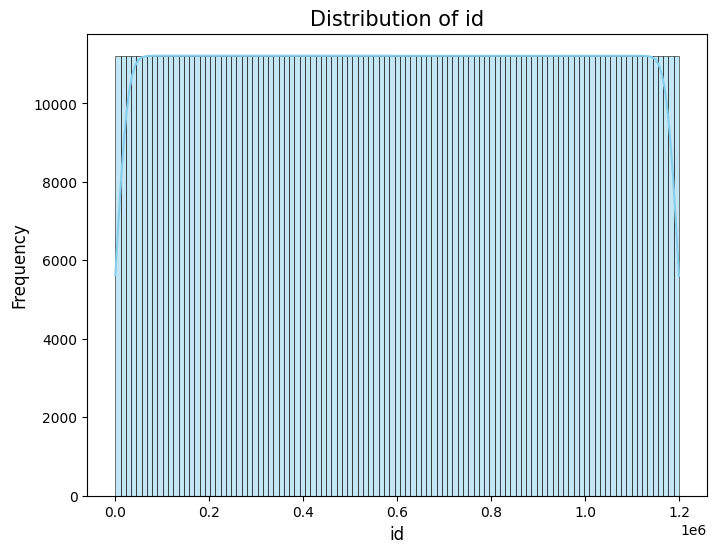

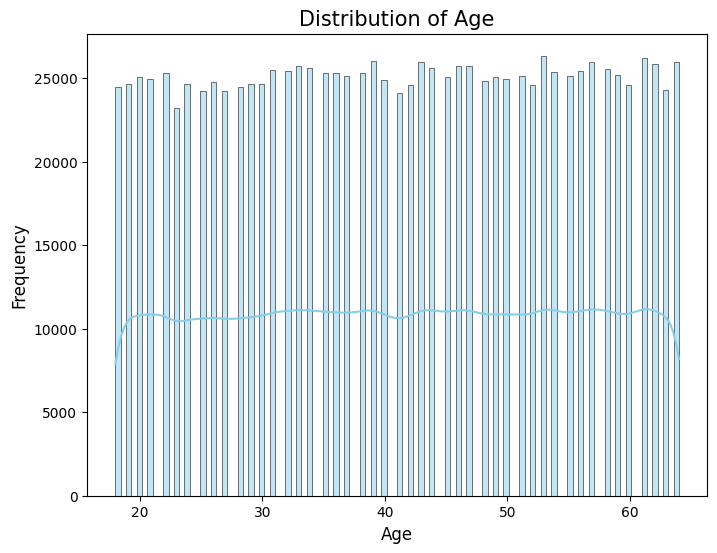

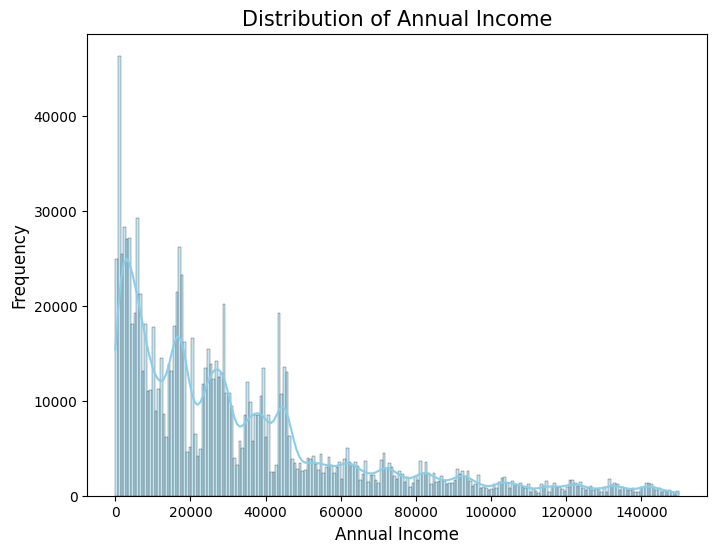

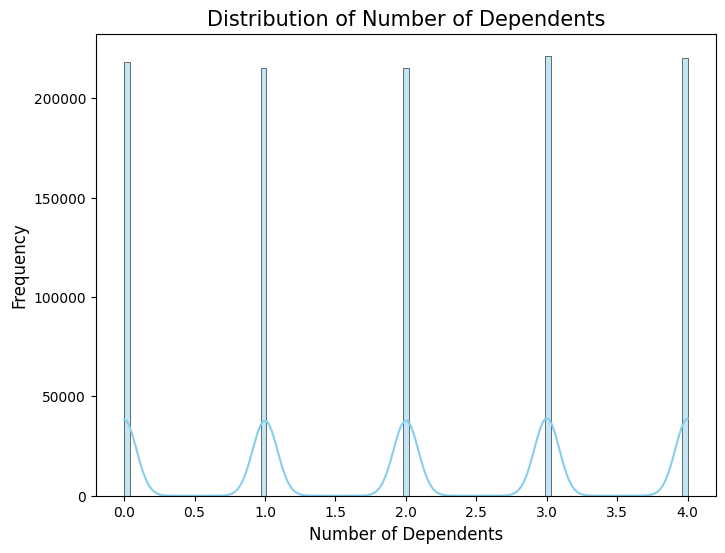

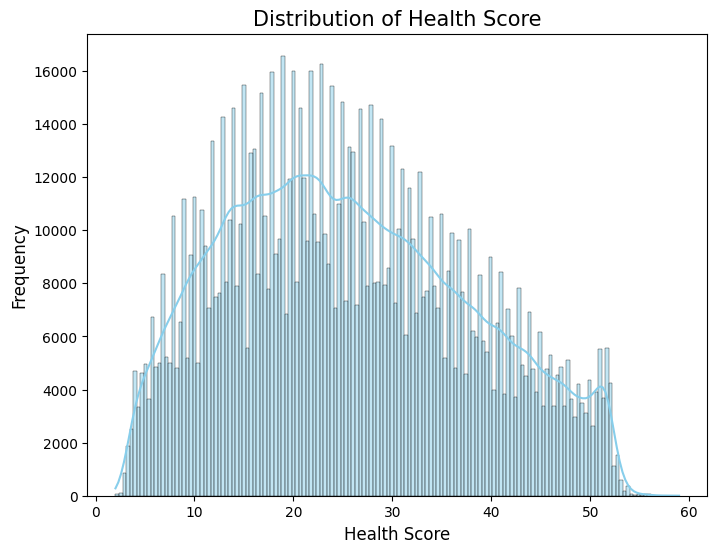

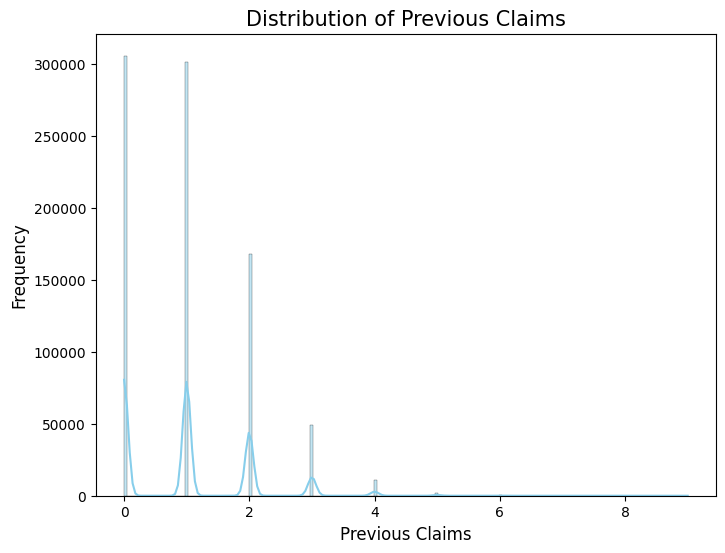

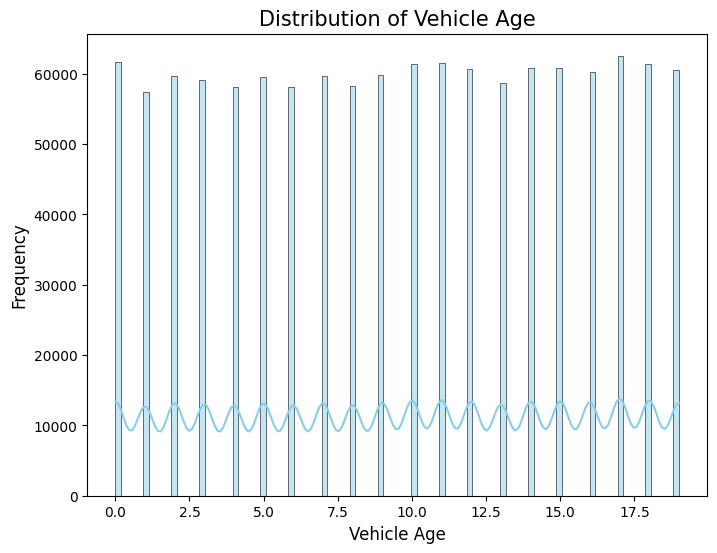

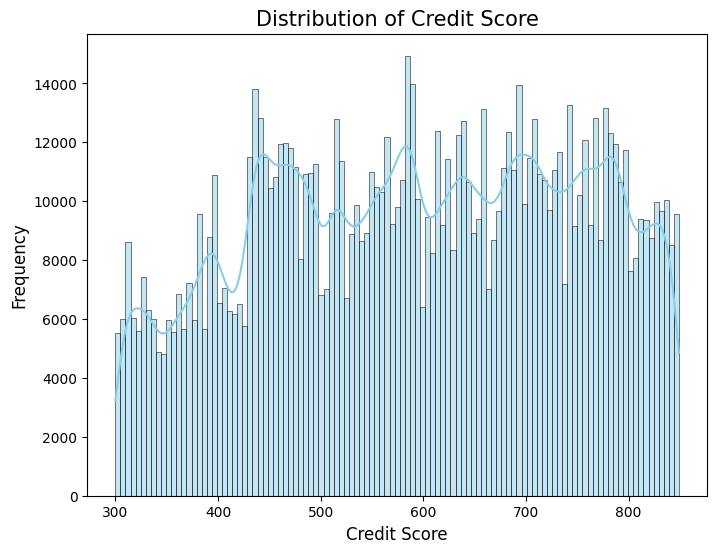

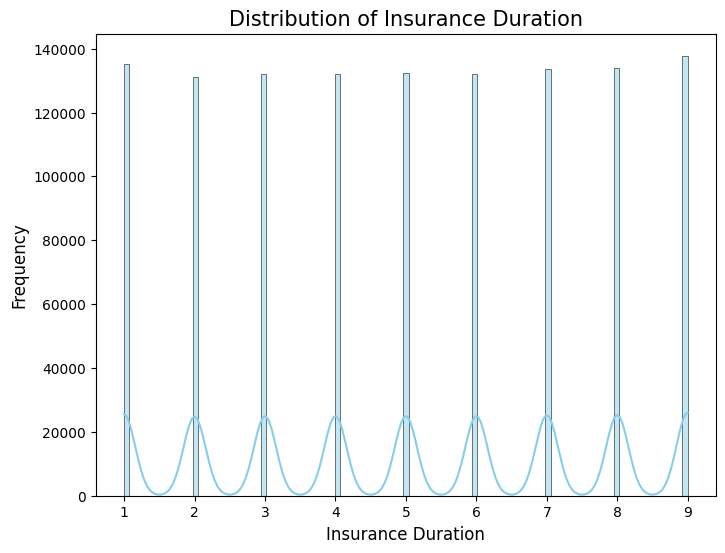

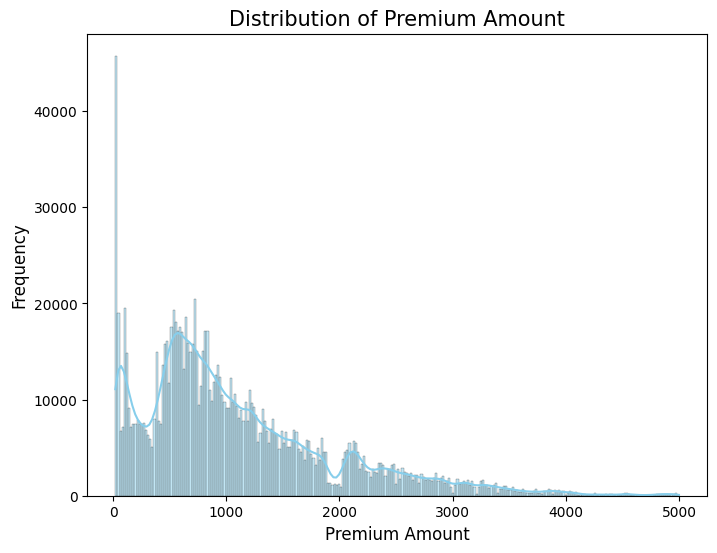

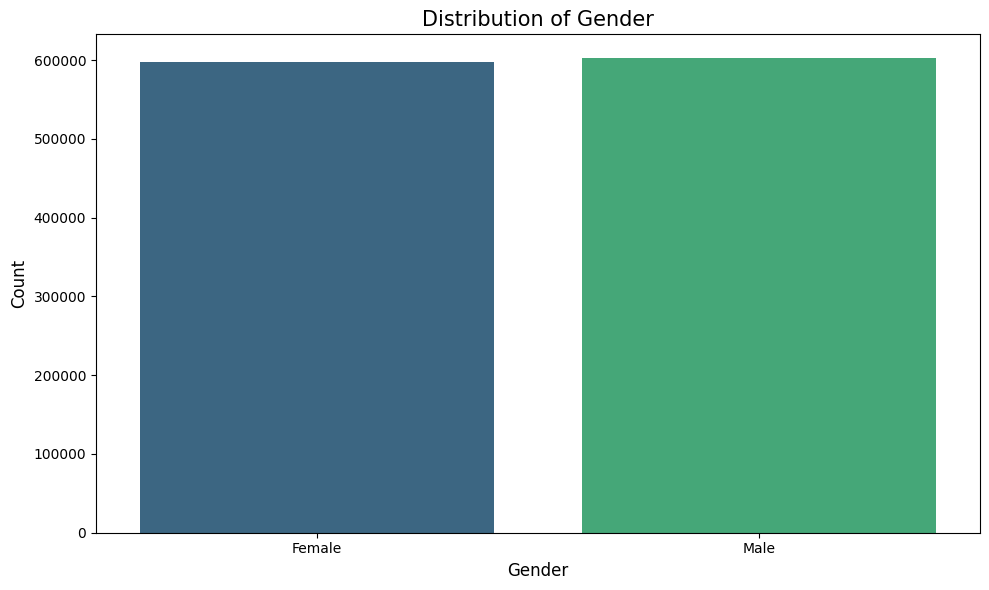

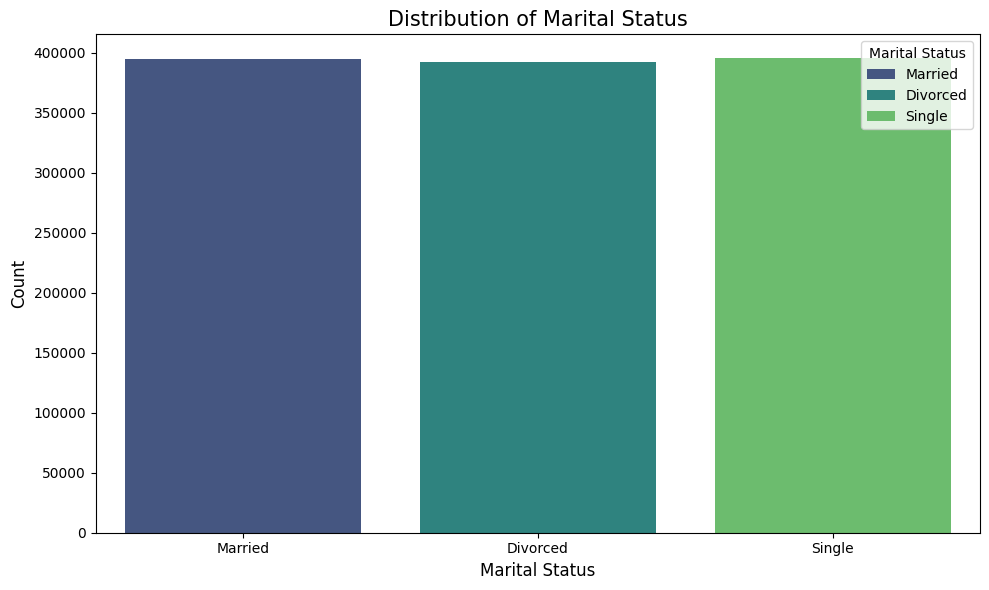

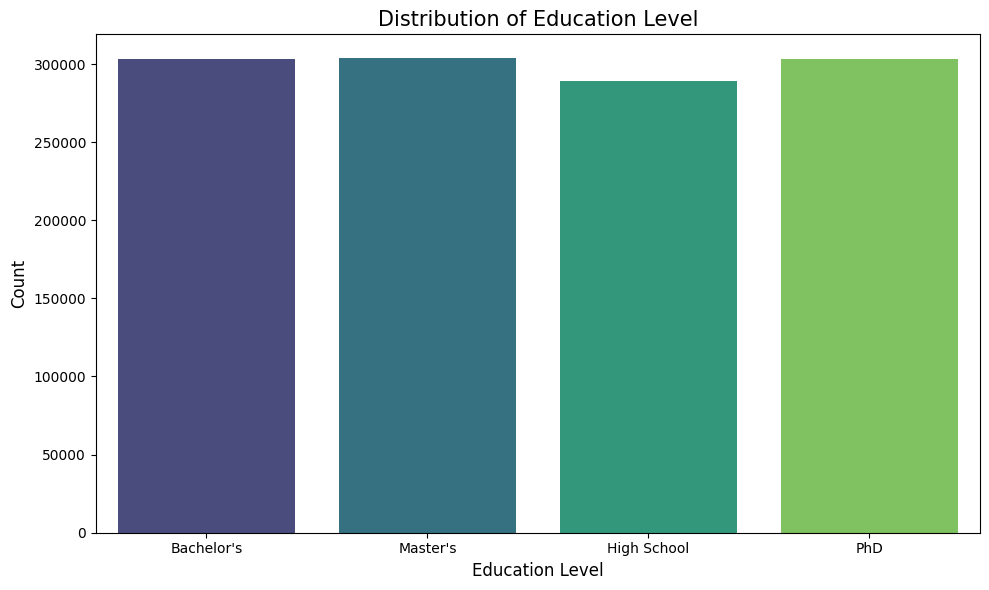

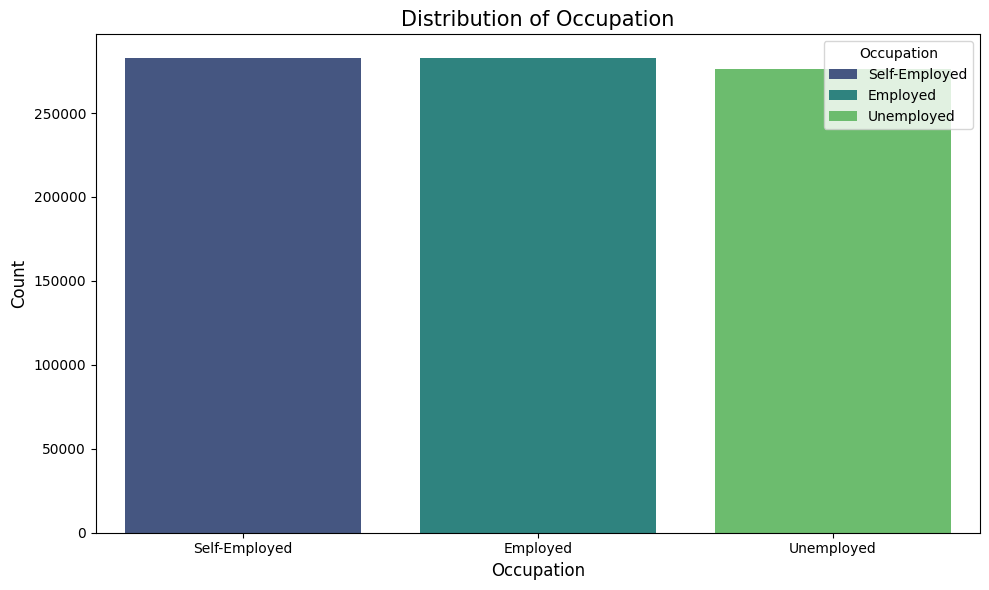

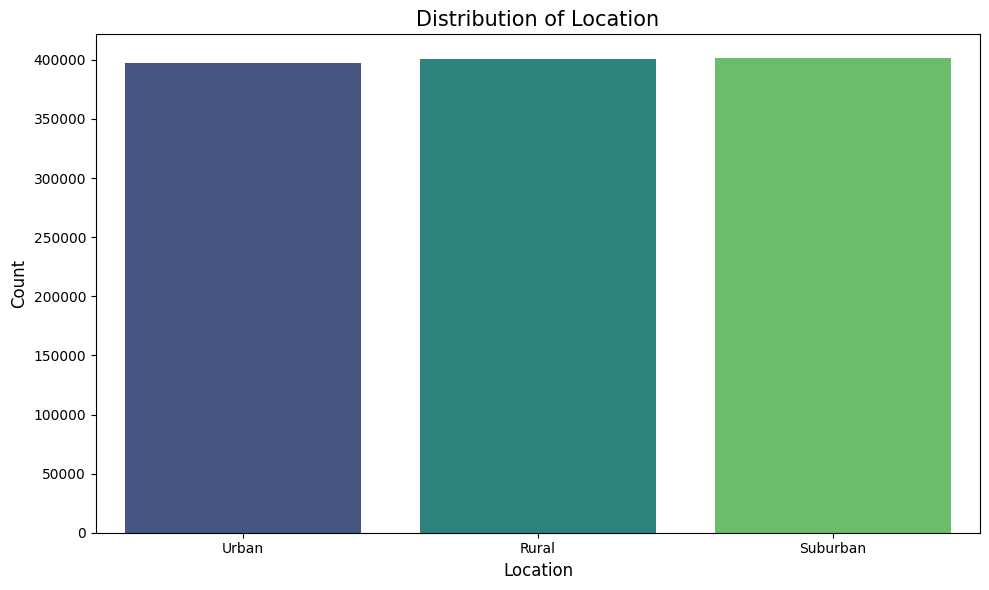

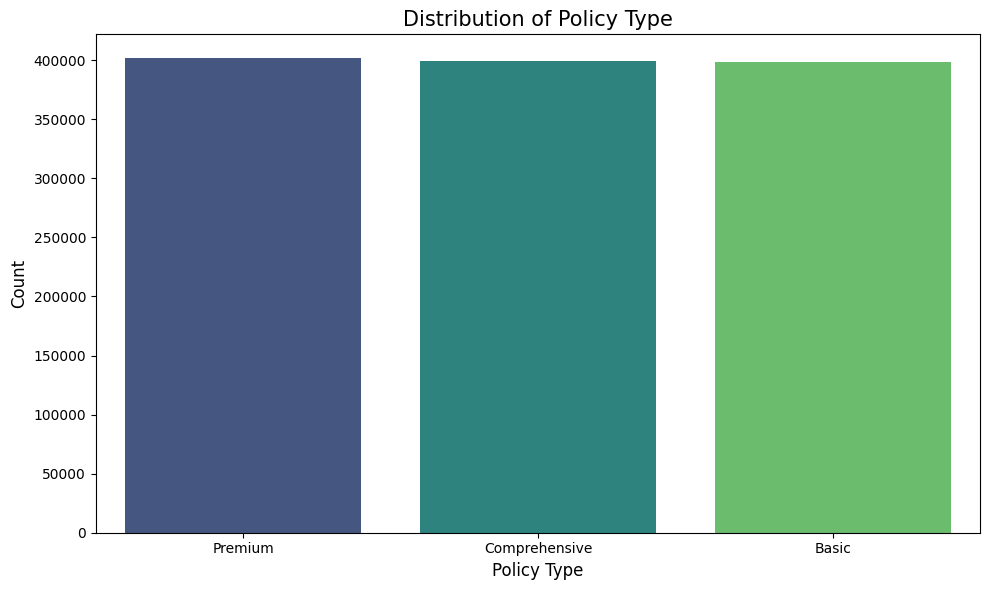

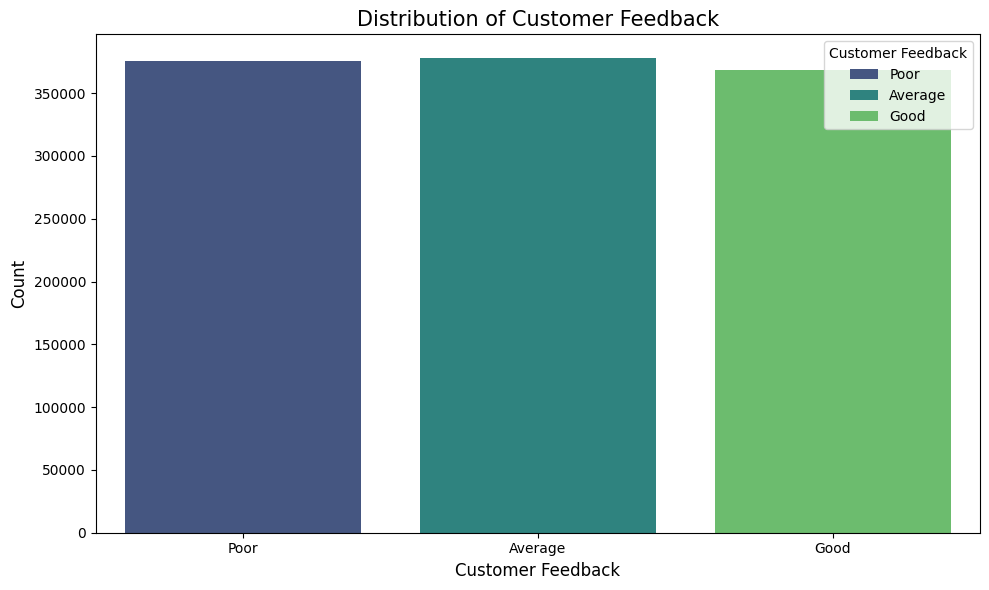

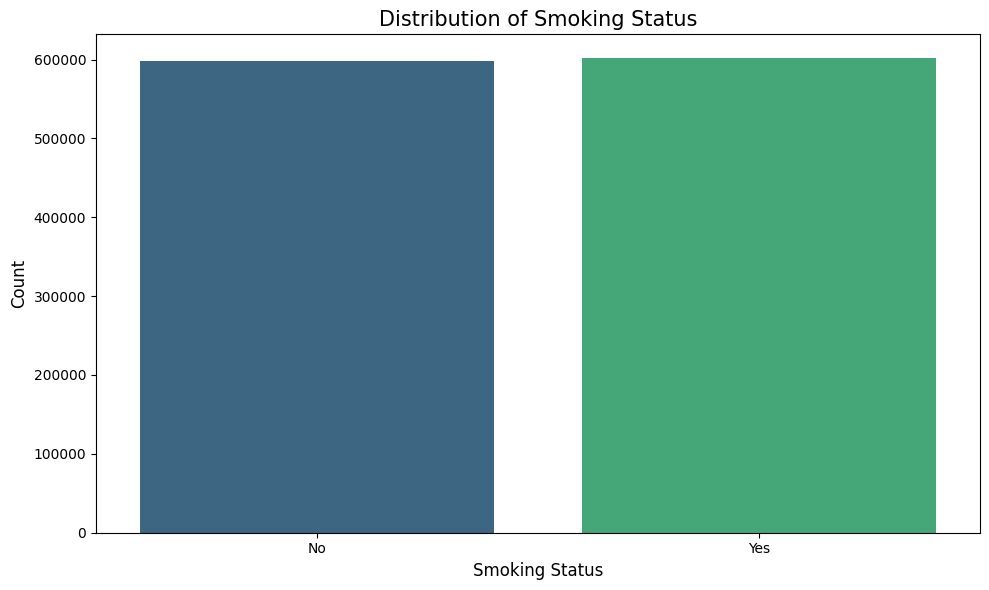

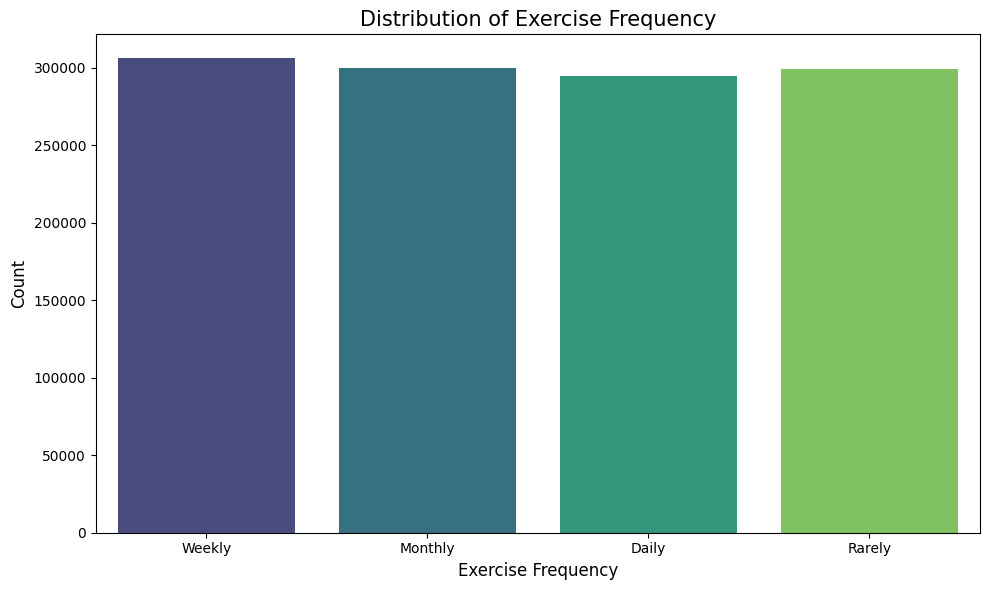

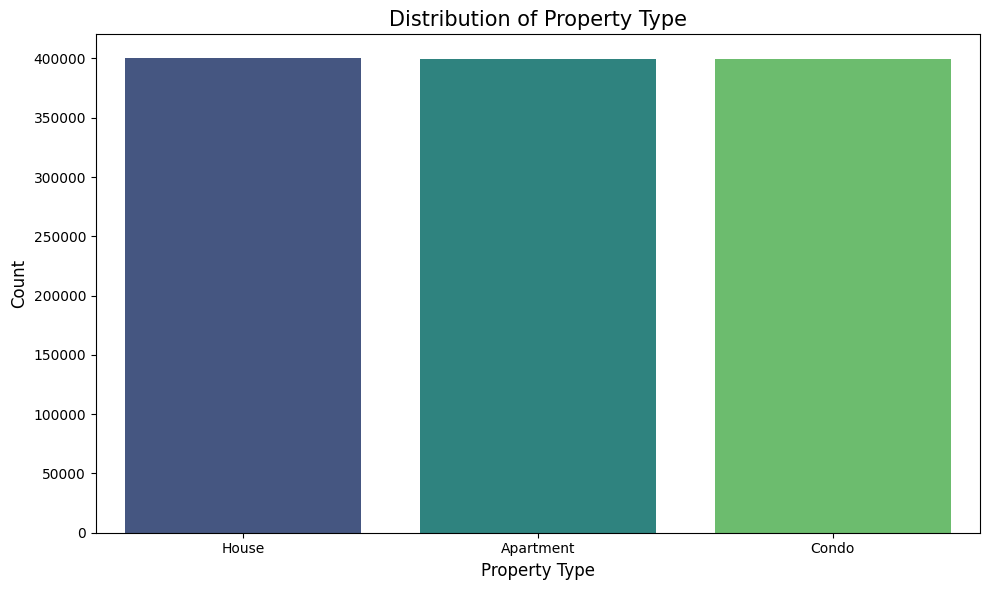

In [6]:
for col in continuous_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df_train[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.show()
for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    
    # Count plot (bar plot showing frequency of each category)
    sns.countplot(x=col, hue=col, data=df_train, palette='viridis')
    
    plt.title(f'Distribution of {col}', fontsize=15)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.tight_layout()  # Adjust layout to prevent cutting off labels
    plt.show()

Let's transform Policy Start Date into something useful and create new features.
Ideas for new features:

1. Ratio between Annual Income and Number of Dependents
2. Ratio between Annual Income and Previous Claims
3. Ratio between Previous Claims and Insurance Duration
4. Ratio between Previous Claims and Credit Score
5. Ratio between Age and Credit Score
6. Ratio between Education Level and Credit Score


Let's also calculate the skew from our continuous values to select features that reguire log transformation

In [7]:
df_train[continuous_columns].skew().sort_values(ascending=False).apply(lambda x: format(x, 'f'))

Annual Income            1.470357
Premium Amount           1.240915
Previous Claims          0.905321
Health Score             0.282187
id                       0.000000
Insurance Duration      -0.008793
Age                     -0.012532
Number of Dependents    -0.013255
Vehicle Age             -0.020409
Credit Score            -0.113573
dtype: object

There 3 variables (Annual Income, Premium Amount, Previous Claims) are strongly right skewed and one (Health Score) that is lightly right skewed. We will apply log transformation for all of them,


### 2.2 Handling NaN values 

To do that and create new features we need to first encode our features

In [8]:
continuous_columns_01 = continuous_columns.copy()
continuous_columns_01.remove('Premium Amount')

In [9]:
print(df_train[continuous_columns].min().apply(lambda x: format(x, 'f')), '\n', df_test[continuous_columns_01].min().apply(lambda x: format(x, 'f')))

id                        0.000000
Age                      18.000000
Annual Income             1.000000
Number of Dependents      0.000000
Health Score              2.012237
Previous Claims           0.000000
Vehicle Age               0.000000
Credit Score            300.000000
Insurance Duration        1.000000
Premium Amount           20.000000
dtype: object 
 id                      1200000.000000
Age                          18.000000
Annual Income                 2.000000
Number of Dependents          0.000000
Health Score                  1.646561
Previous Claims               0.000000
Vehicle Age                   0.000000
Credit Score                300.000000
Insurance Duration            1.000000
dtype: object


Since there are no negative values we will impute NaNs with -1.

In [10]:
df_train.isna().sum()

id                           0
Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [11]:
# Fill NaN values for continuous columns with -1
df_train[continuous_columns] = df_train[continuous_columns].fillna(-1)
df_test[continuous_columns_01] = df_test[continuous_columns_01].fillna(-1)

# Fill NaN values for categorical columns with np.nan
df_train[categorical_columns] = df_train[categorical_columns].fillna('Unknown')
df_test[categorical_columns] = df_test[categorical_columns].fillna('Unknown')

print(df_train.isnull().sum())
print(df_test.isnull().sum())

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64
id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0

In [12]:
nominal_features = ['Gender', 'Marital Status', 'Occupation', 'Location', 'Smoking Status', 'Property Type']
ordinal_features = ['Education Level', 'Policy Type', 'Customer Feedback', 'Exercise Frequency']
# Define the order for ordinal encoding
ordinal_categories = [
    ['High School', "Bachelor's", "Master's", 'PhD'],  # Education Level
    ['Basic', 'Comprehensive', 'Premium'],            # Policy Type
    ['Poor', 'Average', 'Good'],                       # Customer Feedback
    ['Rarely', 'Monthly', 'Weekly', 'Daily'],          # Exercise Frequency
]

In [13]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(categories=ordinal_categories, handle_unknown='use_encoded_value', 
                                unknown_value=np.nan, encoded_missing_value=np.nan)

ordinal_encoded = ordinal_encoder.fit_transform(df_train[ordinal_features])

ordinal_encoded_df = pd.DataFrame(ordinal_encoded, columns=ordinal_features)

df_train[ordinal_features] = ordinal_encoded_df

# View the transformed DataFrame
df_train.head(1)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,1.0,Self-Employed,22.598761,Urban,2.0,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,0.0,No,2.0,House,2869.0


In [14]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='error', sparse_output=False).set_output(transform='pandas')
ohetrans = one_hot_encoder.fit_transform(df_train[nominal_features])
df_train = pd.concat([df_train, ohetrans], axis=1).drop(columns=nominal_features)
df_train.head(1)

,id,Age,Annual Income,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Exercise Frequency,Premium Amount,Gender_Female,Gender_Male,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Unknown,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Occupation_Unknown,Location_Rural,Location_Suburban,Location_Urban,Smoking Status_No,Smoking Status_Yes,Property Type_Apartment,Property Type_Condo,Property Type_House
0,0,19.0,10049.0,1.0,1.0,22.598761,2.0,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,0.0,2.0,2869.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


### 2.3 Feature Engineering

In [15]:
from sklearn.decomposition import PCA

health_features = df_train[['Health Score', 'Smoking Status_No', 'Smoking Status_Yes', 'Exercise Frequency']]
pca = PCA(n_components=1)
df_train['PCA_Health'] = pca.fit_transform(health_features)
df_train.head(1)

,id,Age,Annual Income,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Exercise Frequency,Premium Amount,Gender_Female,Gender_Male,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Unknown,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Occupation_Unknown,Location_Rural,Location_Suburban,Location_Urban,Smoking Status_No,Smoking Status_Yes,Property Type_Apartment,Property Type_Condo,Property Type_House,PCA_Health
0,0,19.0,10049.0,1.0,1.0,22.598761,2.0,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,0.0,2.0,2869.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-1.372171


In [16]:
from datetime import timedelta


def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    """
    Perform feature engineering on the given DataFrame.
    
    This function transforms the 'Policy Start Date' into Year, Month, Day and cyclic features
    and creates new features based on the specified ratios. 
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing the relevant features.
    
    Returns:
    pd.DataFrame: The DataFrame with new features added.
    """
    
    df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'])
    
    # Transform 'Policy Start Date' into various date-related features
    df['Year'] = df['Policy Start Date'].dt.year
    df['Day'] = df['Policy Start Date'].dt.day
    df['Month'] = df['Policy Start Date'].dt.month
    df['Day_of_year'] = df['Policy Start Date'].dt.dayofyear
    df['Day_of_week'] = df['Policy Start Date'].dt.weekday
    df['Sin_day_of_week'] = np.sin(2 * np.pi * df['Day_of_week'] / 7)
    df['Cos_day_of_week'] = np.cos(2 * np.pi * df['Day_of_week'] / 7)
    
    df = df.drop(columns='Policy Start Date')
    # Create new features based on the specified ratios
    df['Income_to_Dependants'] = df['Annual Income'] / np.maximum(df['Number of Dependents'], 1)
    df['Income_to_Claims'] = df['Annual Income'] / np.maximum(df['Previous Claims'], 1)
    df['Claims_to_Duration'] = df['Previous Claims'] / np.maximum(df['Insurance Duration'], 1)
    df['Claims_to_Credit'] = df['Previous Claims'] / np.maximum(df['Credit Score'], 1)
    df['Claims_to_Income'] = df['Previous Claims'] / np.maximum(df['Annual Income'], 1)
    df['Dependents_to_Duration'] = df['Number of Dependents'] / np.maximum(df['Insurance Duration'], 1)

    return df

In [17]:
df_train = feature_engineering(df_train)

# Display the transformed DataFrame
df_train.head(3)

,id,Age,Annual Income,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Exercise Frequency,Premium Amount,Gender_Female,Gender_Male,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Unknown,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Occupation_Unknown,Location_Rural,Location_Suburban,Location_Urban,Smoking Status_No,Smoking Status_Yes,Property Type_Apartment,Property Type_Condo,Property Type_House,PCA_Health,Year,Day,Month,Day_of_year,Day_of_week,Sin_day_of_week,Cos_day_of_week,Income_to_Dependants,Income_to_Claims,Claims_to_Duration,Claims_to_Credit,Claims_to_Income,Dependents_to_Duration
0,0,19.0,10049.0,1.0,1.0,22.598761,2.0,2.0,17.0,372.0,5.0,0.0,2.0,2869.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-1.372171,2023,23,12,357,5,-0.974928,-0.222521,10049.000000,5024.5,0.400000,0.005376,0.000199,0.2
1,1,39.0,31678.0,3.0,2.0,15.569731,1.0,1.0,12.0,694.0,2.0,1.0,1.0,1483.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-8.401399,2023,12,6,163,0,0.000000,1.000000,10559.333333,31678.0,0.500000,0.001441,0.000032,1.5
2,2,23.0,25602.0,3.0,0.0,47.177549,2.0,1.0,14.0,-1.0,3.0,2.0,2.0,567.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,23.206379,2023,30,9,273,5,-0.974928,-0.222521,8534.000000,25602.0,0.333333,1.000000,0.000039,1.0


In [18]:
## Let's do the same with test
ordinal_encoded_test = ordinal_encoder.fit_transform(df_test[ordinal_features])

ordinal_encoded_df_test = pd.DataFrame(ordinal_encoded_test, columns=ordinal_features)

df_test[ordinal_features] = ordinal_encoded_df_test

# View the transformed DataFrame
df_test.head(1)

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,Unknown,4.0,1.0,Self-Employed,7.657981,Rural,0.0,-1.0,19.0,-1.0,1.0,2023-06-04 15:21:39.245086,0.0,Yes,2.0,House


In [19]:
ohetrans = one_hot_encoder.fit_transform(df_test[nominal_features])
df_test = pd.concat([df_test, ohetrans], axis=1).drop(columns=nominal_features)
df_test.head(1)

,id,Age,Annual Income,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Exercise Frequency,Gender_Female,Gender_Male,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Unknown,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Occupation_Unknown,Location_Rural,Location_Suburban,Location_Urban,Smoking Status_No,Smoking Status_Yes,Property Type_Apartment,Property Type_Condo,Property Type_House
0,1200000,28.0,2310.0,4.0,1.0,7.657981,0.0,-1.0,19.0,-1.0,1.0,2023-06-04 15:21:39.245086,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [20]:
health_features = df_test[['Health Score', 'Smoking Status_No', 'Smoking Status_Yes', 'Exercise Frequency']]
df_test['PCA_Health'] = pca.fit_transform(health_features)
df_test.head(1)

,id,Age,Annual Income,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Exercise Frequency,Gender_Female,Gender_Male,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Unknown,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Occupation_Unknown,Location_Rural,Location_Suburban,Location_Urban,Smoking Status_No,Smoking Status_Yes,Property Type_Apartment,Property Type_Condo,Property Type_House,PCA_Health
0,1200000,28.0,2310.0,4.0,1.0,7.657981,0.0,-1.0,19.0,-1.0,1.0,2023-06-04 15:21:39.245086,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-16.310168


In [21]:
df_test = feature_engineering(df_test)

# Display the transformed DataFrame
df_test.head(3)

,id,Age,Annual Income,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Exercise Frequency,Gender_Female,Gender_Male,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Unknown,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Occupation_Unknown,Location_Rural,Location_Suburban,Location_Urban,Smoking Status_No,Smoking Status_Yes,Property Type_Apartment,Property Type_Condo,Property Type_House,PCA_Health,Year,Day,Month,Day_of_year,Day_of_week,Sin_day_of_week,Cos_day_of_week,Income_to_Dependants,Income_to_Claims,Claims_to_Duration,Claims_to_Credit,Claims_to_Income,Dependents_to_Duration
0,1200000,28.0,2310.0,4.0,1.0,7.657981,0.0,-1.0,19.0,-1.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-16.310168,2023,4,6,155,6,-0.781831,0.623490,577.5,2310.0,-1.000000,-1.000000,-0.000433,4.00
1,1200001,31.0,126031.0,2.0,2.0,13.381379,2.0,-1.0,14.0,372.0,8.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,-10.586716,2024,22,4,113,0,0.000000,1.000000,63015.5,126031.0,-0.125000,-0.002688,-0.000008,0.25
2,1200002,47.0,17092.0,0.0,3.0,24.354527,1.0,-1.0,16.0,819.0,9.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.386405,2023,5,4,95,2,0.974928,-0.222521,17092.0,17092.0,-0.111111,-0.001221,-0.000059,0.00


Since there are features that are right skewed. We will take the log of them

In [22]:
skewed_features = ['Annual Income', 'Previous Claims', 'Health Score']

for feature in skewed_features:
    df_train[feature] =  np.log1p(df_train[feature])
    df_test[feature] =  np.log1p(df_test[feature])

In [23]:
df_train.head(1)

,id,Age,Annual Income,Number of Dependents,Education Level,Health Score,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Exercise Frequency,Premium Amount,Gender_Female,Gender_Male,Marital Status_Divorced,Marital Status_Married,Marital Status_Single,Marital Status_Unknown,Occupation_Employed,Occupation_Self-Employed,Occupation_Unemployed,Occupation_Unknown,Location_Rural,Location_Suburban,Location_Urban,Smoking Status_No,Smoking Status_Yes,Property Type_Apartment,Property Type_Condo,Property Type_House,PCA_Health,Year,Day,Month,Day_of_year,Day_of_week,Sin_day_of_week,Cos_day_of_week,Income_to_Dependants,Income_to_Claims,Claims_to_Duration,Claims_to_Credit,Claims_to_Income,Dependents_to_Duration
0,0,19.0,9.215328,1.0,1.0,3.161194,2.0,1.098612,17.0,372.0,5.0,0.0,2.0,2869.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,-1.372171,2023,23,12,357,5,-0.974928,-0.222521,10049.0,5024.5,0.4,0.005376,0.000199,0.2


In [24]:
df_train.columns

Index(['id', 'Age', 'Annual Income', 'Number of Dependents', 'Education Level',
       'Health Score', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Customer Feedback',
       'Exercise Frequency', 'Premium Amount', 'Gender_Female', 'Gender_Male',
       'Marital Status_Divorced', 'Marital Status_Married',
       'Marital Status_Single', 'Marital Status_Unknown',
       'Occupation_Employed', 'Occupation_Self-Employed',
       'Occupation_Unemployed', 'Occupation_Unknown', 'Location_Rural',
       'Location_Suburban', 'Location_Urban', 'Smoking Status_No',
       'Smoking Status_Yes', 'Property Type_Apartment', 'Property Type_Condo',
       'Property Type_House', 'PCA_Health', 'Year', 'Day', 'Month',
       'Day_of_year', 'Day_of_week', 'Sin_day_of_week', 'Cos_day_of_week',
       'Income_to_Dependants', 'Income_to_Claims', 'Claims_to_Duration',
       'Claims_to_Credit', 'Claims_to_Income', 'Dependents_to_Duration'],
      dtype='object

In [25]:
df_train.min()

id                             0.000000
Age                           -1.000000
Annual Income                      -inf
Number of Dependents          -1.000000
Education Level                0.000000
Health Score                       -inf
Policy Type                    0.000000
Previous Claims                    -inf
Vehicle Age                   -1.000000
Credit Score                  -1.000000
Insurance Duration            -1.000000
Customer Feedback              0.000000
Exercise Frequency             0.000000
Premium Amount                20.000000
Gender_Female                  0.000000
Gender_Male                    0.000000
Marital Status_Divorced        0.000000
Marital Status_Married         0.000000
Marital Status_Single          0.000000
Marital Status_Unknown         0.000000
Occupation_Employed            0.000000
Occupation_Self-Employed       0.000000
Occupation_Unemployed          0.000000
Occupation_Unknown             0.000000
Location_Rural                 0.000000


### 2.4 Feature Selection

In [26]:
from sklearn.model_selection import train_test_split
X = df_train.drop(columns=['Premium Amount', 'id'])  # Features
y_log = np.log1p(df_train['Premium Amount'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y_log, test_size=0.2,  shuffle=True, random_state=42)
print(f'''
X_train shape: {X_train.shape}
X_valid shape: {X_valid.shape}
y_train shape: {y_train.shape}
y_valid shape: {y_valid.shape} 
''')


X_train shape: (960000, 44)
X_valid shape: (240000, 44)
y_train shape: (960000,)
y_valid shape: (240000,) 



In [27]:
from lightgbm import LGBMRegressor

# Initialize the model
model_lgb_features = LGBMRegressor(n_jobs=-1, random_state=42)

# Fit the model
model_lgb_features.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='rmse',
)

# Get feature importances
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,  # Use X_train.columns to get the feature names
    'Importance': model_lgb_features.feature_importances_  # Access as an attribute
}).sort_values(by='Importance', ascending=False)

# Print feature importance
print(feature_importance)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 44
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
                     Feature  Importance
8               Credit Score         479
1              Annual Income         322
4               Health Score         310
39          Income_to_Claims         190
10         Customer Feedback         148
41          Claims_to_Credit         133
34               Day_of_year         127
30                PCA_Health         122
31                      Year         113
0                      

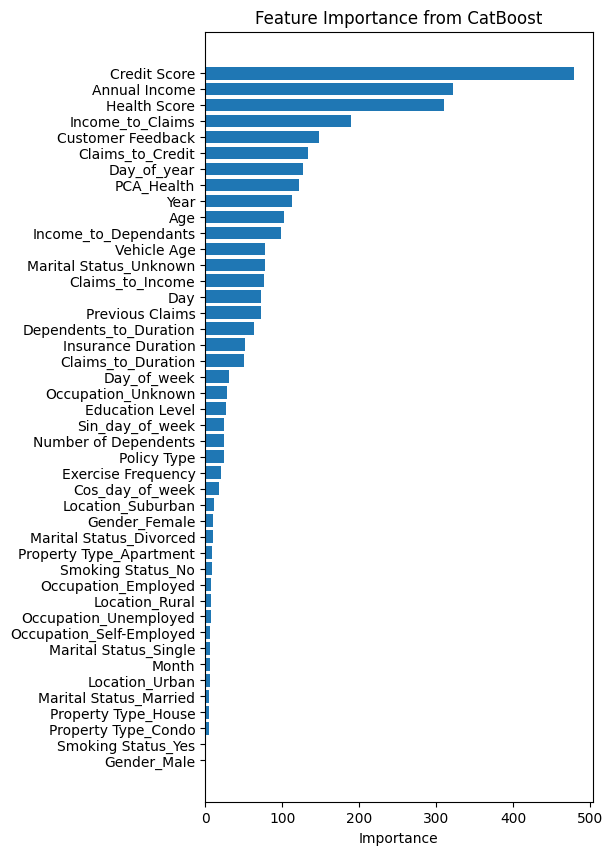

In [28]:
plt.figure(figsize=(5, 10))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance from CatBoost")
plt.show()

In [29]:
feature_importance['Feature'][:20]

8               Credit Score
1              Annual Income
4               Health Score
39          Income_to_Claims
10         Customer Feedback
41          Claims_to_Credit
34               Day_of_year
30                PCA_Health
31                      Year
0                        Age
38      Income_to_Dependants
7                Vehicle Age
17    Marital Status_Unknown
42          Claims_to_Income
32                       Day
6            Previous Claims
43    Dependents_to_Duration
9         Insurance Duration
40        Claims_to_Duration
35               Day_of_week
Name: Feature, dtype: object

## 3. Model Training

In [30]:
from lightgbm import LGBMRegressor
from sklearn.metrics import root_mean_squared_error

# List of k values
k_values = [2, 3, 4, 5, 10, 20, 25, 30]

# Dictionary to store results
results = {}

# Iterate over each k value
for k in k_values:
    # Select top k features
    top_k_features = feature_importance['Feature'][:k]
    
    # Subset training and validation data
    X_train_k = X_train[top_k_features]
    X_valid_k = X_valid[top_k_features]
    
    # Initialize the model
    model_lgb = LGBMRegressor(num_leaves=32, max_depth=5, n_estimators=250, reg_alpha= 0.5, random_state=42, n_jobs=-1)
    
    # Train the model
    model_lgb.fit(
        X_train_k, y_train,
        eval_set=[(X_valid_k, y_valid)],
        eval_metric='rmse',
    )
    
    # Make predictions and evaluate
    y_valid_pred = model_lgb.predict(X_valid_k)
    rmsle = root_mean_squared_error(y_valid, y_valid_pred)
    
    # Store the results
    results[k] = rmsle
    print(f"Top {k} features RMSLE: {rmsle}")

# Display final results
print("\nSummary of RMSE for different k values:")
for k, rmsle in results.items():
    print(f"Top {k} features: RMSLE = {rmsle}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 506
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 2
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

### Fine Tuning Model's hyperparameters

In [31]:
import optuna

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    num_leaves = trial.suggest_int("num_leaves", 8, 100)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-3, 10.0)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-3, 10.0)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 0.1)

    # Select top k features (adjust k as needed or make it a parameter)
    k = 10
    top_k_features = feature_importance['Feature'][:k]
    X_train_k = X_train[top_k_features]
    X_valid_k = X_valid[top_k_features]

    # Initialize the model
    model = LGBMRegressor(
        num_leaves=num_leaves,
        max_depth=max_depth,
        n_estimators=n_estimators,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        learning_rate=learning_rate,
        random_state=42,
        n_jobs=-1
    )

    # Train the model
    model.fit(
        X_train_k, y_train,
        eval_set=[(X_valid_k, y_valid)],
        eval_metric="rmse",
    )

    # Make predictions and compute RMSE
    y_valid_pred = model.predict(X_valid_k)
    rmsle = root_mean_squared_error(y_valid, y_valid_pred)

    return rmsle

# Create an Optuna study and optimize
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

# Display the best hyperparameters
print("Best hyperparameters:")
print(study.best_params)

[I 2025-01-21 22:47:58,582] A new study created in memory with name: no-name-41fb1960-27e4-49d8-a695-cdb80cef43d8
  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Best trial: 0. Best value: 1.05605:   2%|▏         | 1/50 [00:02<01:42,  2.09s/it]

[I 2025-01-21 22:48:00,669] Trial 0 finished with value: 1.0560529176531808 and parameters: {'num_leaves': 80, 'max_depth': 6, 'n_estimators': 245, 'reg_alpha': 0.22831781413402813, 'reg_lambda': 0.1920128362077701, 'learning_rate': 0.004862539383987538}. Best is trial 0 with value: 1.0560529176531808.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 0. Best value: 1.05605:   4%|▍         | 2/50 [00:03<01:15,  1.57s/it]

[I 2025-01-21 22:48:01,870] Trial 1 finished with value: 1.0837803102706 and parameters: {'num_leaves': 81, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0.100248345185216, 'reg_lambda': 2.4797043167147956, 'learning_rate': 0.0012088859342965525}. Best is trial 0 with value: 1.0560529176531808.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 2. Best value: 1.04926:   6%|▌         | 3/50 [00:05<01:27,  1.86s/it]

[I 2025-01-21 22:48:04,085] Trial 2 finished with value: 1.0492572777031968 and parameters: {'num_leaves': 24, 'max_depth': 10, 'n_estimators': 286, 'reg_alpha': 4.23659318001836, 'reg_lambda': 0.916387385072881, 'learning_rate': 0.012275893955326836}. Best is trial 2 with value: 1.0492572777031968.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 2. Best value: 1.04926:   8%|▊         | 4/50 [00:08<01:37,  2.13s/it]

[I 2025-01-21 22:48:06,624] Trial 3 finished with value: 1.0598934253628631 and parameters: {'num_leaves': 56, 'max_depth': 6, 'n_estimators': 322, 'reg_alpha': 1.9803551697668074, 'reg_lambda': 4.792548751498626, 'learning_rate': 0.002820252343064287}. Best is trial 2 with value: 1.0492572777031968.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 2. Best value: 1.04926:  10%|█         | 5/50 [00:10<01:33,  2.07s/it]

[I 2025-01-21 22:48:08,598] Trial 4 finished with value: 1.0593750874421655 and parameters: {'num_leaves': 85, 'max_depth': 3, 'n_estimators': 442, 'reg_alpha': 5.562687050941047, 'reg_lambda': 7.56122456451905, 'learning_rate': 0.009523293094183765}. Best is trial 2 with value: 1.0492572777031968.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 5. Best value: 1.04921:  12%|█▏        | 6/50 [00:11<01:25,  1.94s/it]

[I 2025-01-21 22:48:10,282] Trial 5 finished with value: 1.0492086317005476 and parameters: {'num_leaves': 17, 'max_depth': 9, 'n_estimators': 268, 'reg_alpha': 0.4967667528147479, 'reg_lambda': 0.6263873608161775, 'learning_rate': 0.01875817359954411}. Best is trial 5 with value: 1.0492086317005476.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 5. Best value: 1.04921:  14%|█▍        | 7/50 [00:13<01:25,  1.99s/it]

[I 2025-01-21 22:48:12,368] Trial 6 finished with value: 1.0687023121043737 and parameters: {'num_leaves': 27, 'max_depth': 6, 'n_estimators': 325, 'reg_alpha': 0.017382067077841432, 'reg_lambda': 0.13622783406326647, 'learning_rate': 0.0016814820714573771}. Best is trial 5 with value: 1.0492086317005476.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 5. Best value: 1.04921:  16%|█▌        | 8/50 [00:15<01:20,  1.93s/it]

[I 2025-01-21 22:48:14,168] Trial 7 finished with value: 1.0503220107554323 and parameters: {'num_leaves': 45, 'max_depth': 8, 'n_estimators': 198, 'reg_alpha': 0.2463339651982963, 'reg_lambda': 0.0028303137732084557, 'learning_rate': 0.009792259833098352}. Best is trial 5 with value: 1.0492086317005476.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 8. Best value: 1.04834:  18%|█▊        | 9/50 [00:17<01:18,  1.91s/it]

[I 2025-01-21 22:48:16,052] Trial 8 finished with value: 1.0483420398838095 and parameters: {'num_leaves': 11, 'max_depth': 10, 'n_estimators': 461, 'reg_alpha': 0.6802736576904929, 'reg_lambda': 8.04833025860193, 'learning_rate': 0.08999013251659033}. Best is trial 8 with value: 1.0483420398838095.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 9. Best value: 1.04799:  20%|██        | 10/50 [00:18<01:10,  1.75s/it]

[I 2025-01-21 22:48:17,436] Trial 9 finished with value: 1.047994916533064 and parameters: {'num_leaves': 73, 'max_depth': 9, 'n_estimators': 191, 'reg_alpha': 6.257144076020144, 'reg_lambda': 0.00109546032455157, 'learning_rate': 0.09551811712420262}. Best is trial 9 with value: 1.047994916533064.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 9. Best value: 1.04799:  22%|██▏       | 11/50 [00:19<00:59,  1.52s/it]

[I 2025-01-21 22:48:18,432] Trial 10 finished with value: 1.0480265922783654 and parameters: {'num_leaves': 99, 'max_depth': 8, 'n_estimators': 102, 'reg_alpha': 0.0033468104449624198, 'reg_lambda': 0.0013960141826063464, 'learning_rate': 0.0885829848378583}. Best is trial 9 with value: 1.047994916533064.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 11. Best value: 1.04797:  24%|██▍       | 12/50 [00:20<00:51,  1.36s/it]

[I 2025-01-21 22:48:19,425] Trial 11 finished with value: 1.0479702438146297 and parameters: {'num_leaves': 98, 'max_depth': 8, 'n_estimators': 100, 'reg_alpha': 0.003326998741699832, 'reg_lambda': 0.0018897732533650216, 'learning_rate': 0.08873732749967303}. Best is trial 11 with value: 1.0479702438146297.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 11. Best value: 1.04797:  26%|██▌       | 13/50 [00:21<00:47,  1.27s/it]

[I 2025-01-21 22:48:20,493] Trial 12 finished with value: 1.0480138588983432 and parameters: {'num_leaves': 63, 'max_depth': 8, 'n_estimators': 113, 'reg_alpha': 0.016421925356773854, 'reg_lambda': 0.010585375827373567, 'learning_rate': 0.052880669615169316}. Best is trial 11 with value: 1.0479702438146297.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Best trial: 11. Best value: 1.04797:  28%|██▊       | 14/50 [00:23<00:49,  1.39s/it]

[I 2025-01-21 22:48:22,150] Trial 13 finished with value: 1.048206456417504 and parameters: {'num_leaves': 99, 'max_depth': 7, 'n_estimators': 161, 'reg_alpha': 0.0015198785304318919, 'reg_lambda': 0.018093525616282826, 'learning_rate': 0.035032103043386165}. Best is trial 11 with value: 1.0479702438146297.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 14. Best value: 1.04793:  30%|███       | 15/50 [00:25<00:50,  1.43s/it]

[I 2025-01-21 22:48:23,687] Trial 14 finished with value: 1.0479273979948511 and parameters: {'num_leaves': 69, 'max_depth': 9, 'n_estimators': 155, 'reg_alpha': 0.016915011767646423, 'reg_lambda': 0.00717631346264433, 'learning_rate': 0.037382619675653844}. Best is trial 14 with value: 1.0479273979948511.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 14. Best value: 1.04793:  32%|███▏      | 16/50 [00:26<00:47,  1.40s/it]

[I 2025-01-21 22:48:25,004] Trial 15 finished with value: 1.0484085313218574 and parameters: {'num_leaves': 41, 'max_depth': 7, 'n_estimators': 145, 'reg_alpha': 0.012605345913666847, 'reg_lambda': 0.013900374338655591, 'learning_rate': 0.03219437445910196}. Best is trial 14 with value: 1.0479273979948511.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  34%|███▍      | 17/50 [00:29<01:00,  1.84s/it]

[I 2025-01-21 22:48:27,878] Trial 16 finished with value: 1.0479117147042298 and parameters: {'num_leaves': 72, 'max_depth': 9, 'n_estimators': 401, 'reg_alpha': 0.005388154595899679, 'reg_lambda': 0.005596977679439628, 'learning_rate': 0.03531240334126603}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002527 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  36%|███▌      | 18/50 [00:32<01:13,  2.28s/it]

[I 2025-01-21 22:48:31,189] Trial 17 finished with value: 1.0479499263424221 and parameters: {'num_leaves': 67, 'max_depth': 9, 'n_estimators': 388, 'reg_alpha': 0.03040545661565585, 'reg_lambda': 0.037313338135039106, 'learning_rate': 0.024723485071345887}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  38%|███▊      | 19/50 [00:35<01:16,  2.47s/it]

[I 2025-01-21 22:48:34,110] Trial 18 finished with value: 1.048014099440487 and parameters: {'num_leaves': 47, 'max_depth': 10, 'n_estimators': 388, 'reg_alpha': 0.05143824880952342, 'reg_lambda': 0.005015150716107883, 'learning_rate': 0.046782507126797705}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002357 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Best trial: 16. Best value: 1.04791:  40%|████      | 20/50 [00:38<01:16,  2.56s/it]

[I 2025-01-21 22:48:36,869] Trial 19 finished with value: 1.0496643369474632 and parameters: {'num_leaves': 58, 'max_depth': 5, 'n_estimators': 375, 'reg_alpha': 0.006550629242097523, 'reg_lambda': 0.045024114346178847, 'learning_rate': 0.016730588812768777}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  42%|████▏     | 21/50 [00:43<01:37,  3.37s/it]

[I 2025-01-21 22:48:42,126] Trial 20 finished with value: 1.0485313972226527 and parameters: {'num_leaves': 72, 'max_depth': 9, 'n_estimators': 484, 'reg_alpha': 0.0010843376277637465, 'reg_lambda': 0.005295425674414039, 'learning_rate': 0.006039673764507893}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  44%|████▍     | 22/50 [00:46<01:30,  3.23s/it]

[I 2025-01-21 22:48:45,023] Trial 21 finished with value: 1.047918826730484 and parameters: {'num_leaves': 67, 'max_depth': 9, 'n_estimators': 397, 'reg_alpha': 0.04118807283698909, 'reg_lambda': 0.047301686024457015, 'learning_rate': 0.02626825238326896}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  46%|████▌     | 23/50 [00:49<01:22,  3.06s/it]

[I 2025-01-21 22:48:47,701] Trial 22 finished with value: 1.0482143109831636 and parameters: {'num_leaves': 84, 'max_depth': 10, 'n_estimators': 420, 'reg_alpha': 0.06325276274529398, 'reg_lambda': 0.04652892090130896, 'learning_rate': 0.052685821414840586}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  48%|████▊     | 24/50 [00:51<01:17,  2.96s/it]

[I 2025-01-21 22:48:50,435] Trial 23 finished with value: 1.0479475881445341 and parameters: {'num_leaves': 70, 'max_depth': 9, 'n_estimators': 350, 'reg_alpha': 0.006454557148088637, 'reg_lambda': 0.00584124090630958, 'learning_rate': 0.023892909891037054}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  50%|█████     | 25/50 [00:54<01:12,  2.92s/it]

[I 2025-01-21 22:48:53,248] Trial 24 finished with value: 1.0480354731374795 and parameters: {'num_leaves': 52, 'max_depth': 7, 'n_estimators': 423, 'reg_alpha': 0.03515464060290002, 'reg_lambda': 0.022331621555053176, 'learning_rate': 0.035143923544579736}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  52%|█████▏    | 26/50 [00:57<01:07,  2.80s/it]

[I 2025-01-21 22:48:55,786] Trial 25 finished with value: 1.048046051295972 and parameters: {'num_leaves': 37, 'max_depth': 8, 'n_estimators': 493, 'reg_alpha': 0.1271510972492538, 'reg_lambda': 0.07877433763868974, 'learning_rate': 0.05579858127706398}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  54%|█████▍    | 27/50 [00:59<00:59,  2.60s/it]

[I 2025-01-21 22:48:57,911] Trial 26 finished with value: 1.0482368323203533 and parameters: {'num_leaves': 63, 'max_depth': 9, 'n_estimators': 233, 'reg_alpha': 0.0073783089688853176, 'reg_lambda': 0.008749603904420032, 'learning_rate': 0.016290465064202394}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  56%|█████▌    | 28/50 [01:02<00:59,  2.70s/it]

[I 2025-01-21 22:49:00,833] Trial 27 finished with value: 1.0479800959548407 and parameters: {'num_leaves': 89, 'max_depth': 10, 'n_estimators': 368, 'reg_alpha': 0.002221634064966958, 'reg_lambda': 0.28626810963957255, 'learning_rate': 0.025729912991093336}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Best trial: 16. Best value: 1.04791:  58%|█████▊    | 29/50 [01:04<00:55,  2.64s/it]

[I 2025-01-21 22:49:03,342] Trial 28 finished with value: 1.0480662644294676 and parameters: {'num_leaves': 78, 'max_depth': 7, 'n_estimators': 323, 'reg_alpha': 0.025645945526026427, 'reg_lambda': 0.0027218649743407618, 'learning_rate': 0.04229162052109347}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  60%|██████    | 30/50 [01:07<00:50,  2.52s/it]

[I 2025-01-21 22:49:05,596] Trial 29 finished with value: 1.0517851994935177 and parameters: {'num_leaves': 77, 'max_depth': 8, 'n_estimators': 240, 'reg_alpha': 0.010127873173540776, 'reg_lambda': 0.31213837558423896, 'learning_rate': 0.006007694989288527}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003843 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Best trial: 16. Best value: 1.04791:  62%|██████▏   | 31/50 [01:09<00:47,  2.52s/it]

[I 2025-01-21 22:49:08,100] Trial 30 finished with value: 1.0485791592639613 and parameters: {'num_leaves': 65, 'max_depth': 5, 'n_estimators': 411, 'reg_alpha': 0.003519636392363456, 'reg_lambda': 0.024979773683102915, 'learning_rate': 0.06825257902125656}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  64%|██████▍   | 32/50 [01:12<00:46,  2.60s/it]

[I 2025-01-21 22:49:10,892] Trial 31 finished with value: 1.0479619822060822 and parameters: {'num_leaves': 68, 'max_depth': 9, 'n_estimators': 350, 'reg_alpha': 0.005315324159181801, 'reg_lambda': 0.005920488135426874, 'learning_rate': 0.022407047130354546}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  66%|██████▌   | 33/50 [01:15<00:47,  2.81s/it]

[I 2025-01-21 22:49:14,198] Trial 32 finished with value: 1.04808387636796 and parameters: {'num_leaves': 90, 'max_depth': 9, 'n_estimators': 345, 'reg_alpha': 0.06394949523678448, 'reg_lambda': 0.00341332539134554, 'learning_rate': 0.013382727131168176}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  68%|██████▊   | 34/50 [01:17<00:42,  2.66s/it]

[I 2025-01-21 22:49:16,515] Trial 33 finished with value: 1.0479205681685353 and parameters: {'num_leaves': 72, 'max_depth': 10, 'n_estimators': 291, 'reg_alpha': 0.17222290742751153, 'reg_lambda': 0.00825492111496654, 'learning_rate': 0.028917609274245987}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002466 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  70%|███████   | 35/50 [01:20<00:38,  2.54s/it]

[I 2025-01-21 22:49:18,776] Trial 34 finished with value: 1.0479676199333947 and parameters: {'num_leaves': 76, 'max_depth': 10, 'n_estimators': 283, 'reg_alpha': 0.22096776486875777, 'reg_lambda': 0.07917847306168686, 'learning_rate': 0.03128730598016322}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  72%|███████▏  | 36/50 [01:22<00:32,  2.34s/it]

[I 2025-01-21 22:49:20,656] Trial 35 finished with value: 1.0480326524576622 and parameters: {'num_leaves': 60, 'max_depth': 10, 'n_estimators': 305, 'reg_alpha': 0.09955962943634032, 'reg_lambda': 0.010305149115906943, 'learning_rate': 0.06363568204014496}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Best trial: 16. Best value: 1.04791:  74%|███████▍  | 37/50 [01:24<00:29,  2.24s/it]

[I 2025-01-21 22:49:22,668] Trial 36 finished with value: 1.0576653427945697 and parameters: {'num_leaves': 82, 'max_depth': 3, 'n_estimators': 455, 'reg_alpha': 0.7556039509143944, 'reg_lambda': 0.03175925714628806, 'learning_rate': 0.011689325484488606}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  76%|███████▌  | 38/50 [01:26<00:25,  2.15s/it]

[I 2025-01-21 22:49:24,594] Trial 37 finished with value: 1.0479221360760462 and parameters: {'num_leaves': 56, 'max_depth': 9, 'n_estimators': 274, 'reg_alpha': 0.16468454858659015, 'reg_lambda': 0.01465445226921886, 'learning_rate': 0.039789164147964136}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  78%|███████▊  | 39/50 [01:28<00:24,  2.19s/it]

[I 2025-01-21 22:49:26,879] Trial 38 finished with value: 1.0498883827626782 and parameters: {'num_leaves': 53, 'max_depth': 10, 'n_estimators': 260, 'reg_alpha': 2.191794228173622, 'reg_lambda': 1.1068167708601955, 'learning_rate': 0.007618608415090507}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  80%|████████  | 40/50 [01:30<00:22,  2.20s/it]

[I 2025-01-21 22:49:29,107] Trial 39 finished with value: 1.048275607387149 and parameters: {'num_leaves': 34, 'max_depth': 8, 'n_estimators': 297, 'reg_alpha': 0.18053367892867891, 'reg_lambda': 0.11781143664352388, 'learning_rate': 0.019602337721872462}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  82%|████████▏ | 41/50 [01:32<00:20,  2.26s/it]

[I 2025-01-21 22:49:31,493] Trial 40 finished with value: 1.0603771360836511 and parameters: {'num_leaves': 49, 'max_depth': 10, 'n_estimators': 275, 'reg_alpha': 0.5612796605394378, 'reg_lambda': 0.015467810268113868, 'learning_rate': 0.0027459579630048445}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  84%|████████▍ | 42/50 [01:34<00:16,  2.09s/it]

[I 2025-01-21 22:49:33,199] Trial 41 finished with value: 1.0479677637505382 and parameters: {'num_leaves': 57, 'max_depth': 9, 'n_estimators': 222, 'reg_alpha': 0.3844558249188344, 'reg_lambda': 0.008641405072505479, 'learning_rate': 0.04117237837014561}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  86%|████████▌ | 43/50 [01:36<00:13,  1.93s/it]

[I 2025-01-21 22:49:34,742] Trial 42 finished with value: 1.0479746463473618 and parameters: {'num_leaves': 71, 'max_depth': 9, 'n_estimators': 165, 'reg_alpha': 0.0970082675445767, 'reg_lambda': 0.003682124320185911, 'learning_rate': 0.034285116885105174}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  88%|████████▊ | 44/50 [01:38<00:12,  2.05s/it]

[I 2025-01-21 22:49:37,076] Trial 43 finished with value: 1.0479786407334586 and parameters: {'num_leaves': 61, 'max_depth': 9, 'n_estimators': 256, 'reg_alpha': 0.020934012584628577, 'reg_lambda': 0.00194353940416167, 'learning_rate': 0.027686118727690834}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  90%|█████████ | 45/50 [01:40<00:10,  2.07s/it]

[I 2025-01-21 22:49:39,187] Trial 44 finished with value: 1.0480796770950433 and parameters: {'num_leaves': 74, 'max_depth': 8, 'n_estimators': 307, 'reg_alpha': 0.3051786615151322, 'reg_lambda': 0.06290571156517635, 'learning_rate': 0.06526332916249922}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  92%|█████████▏| 46/50 [01:43<00:09,  2.28s/it]

[I 2025-01-21 22:49:41,951] Trial 45 finished with value: 1.0481359351460888 and parameters: {'num_leaves': 89, 'max_depth': 10, 'n_estimators': 407, 'reg_alpha': 0.9851814232165195, 'reg_lambda': 0.014618033783568454, 'learning_rate': 0.044001674819372644}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  94%|█████████▍| 47/50 [01:45<00:06,  2.23s/it]

[I 2025-01-21 22:49:44,063] Trial 46 finished with value: 1.0480913893856587 and parameters: {'num_leaves': 80, 'max_depth': 9, 'n_estimators': 218, 'reg_alpha': 0.1468836809063965, 'reg_lambda': 0.007857557629825911, 'learning_rate': 0.02028285628290196}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003955 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

Best trial: 16. Best value: 1.04791:  96%|█████████▌| 48/50 [01:46<00:03,  1.89s/it]

[I 2025-01-21 22:49:45,169] Trial 47 finished with value: 1.0516394665275053 and parameters: {'num_leaves': 66, 'max_depth': 6, 'n_estimators': 129, 'reg_alpha': 0.045970165874973525, 'reg_lambda': 0.0017572109925990678, 'learning_rate': 0.01474431738662392}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791:  98%|█████████▊| 49/50 [01:48<00:02,  2.02s/it]

[I 2025-01-21 22:49:47,490] Trial 48 finished with value: 1.0481600530081028 and parameters: {'num_leaves': 50, 'max_depth': 10, 'n_estimators': 438, 'reg_alpha': 0.01385692957394562, 'reg_lambda': 0.19617286454057759, 'learning_rate': 0.07416542696696138}. Best is trial 16 with value: 1.0479117147042298.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1831
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848


Best trial: 16. Best value: 1.04791: 100%|██████████| 50/50 [01:50<00:00,  2.21s/it]

[I 2025-01-21 22:49:49,074] Trial 49 finished with value: 1.0481525580460402 and parameters: {'num_leaves': 43, 'max_depth': 8, 'n_estimators': 194, 'reg_alpha': 0.08789738751383526, 'reg_lambda': 0.02280262534406551, 'learning_rate': 0.0293226715649717}. Best is trial 16 with value: 1.0479117147042298.
Best hyperparameters:
{'num_leaves': 72, 'max_depth': 9, 'n_estimators': 401, 'reg_alpha': 0.005388154595899679, 'reg_lambda': 0.005596977679439628, 'learning_rate': 0.03531240334126603}


In [32]:
# Train the final model using the best parameters
best_params = study.best_params

final_model = LGBMRegressor(
    num_leaves=best_params["num_leaves"],
    max_depth=best_params["max_depth"],
    n_estimators=best_params["n_estimators"],
    reg_alpha=best_params["reg_alpha"],
    reg_lambda=best_params["reg_lambda"],
    learning_rate=best_params["learning_rate"],
    random_state=42,
    n_jobs=-1
)

# Train with the final set of features
k = 30
final_top_k_features = feature_importance['Feature'][:k]
X_train_k = X_train[final_top_k_features]
X_valid_k = X_valid[final_top_k_features]

final_model.fit(
    X_train_k, y_train,
    eval_set=[(X_valid_k, y_valid)],
    eval_metric="rmse"
)

# Evaluate final model
final_predictions = final_model.predict(X_valid_k)
final_rmsle = root_mean_squared_error(y_valid, final_predictions)
print(f"Final model RMSLE: {final_rmsle}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2542
[LightGBM] [Info] Number of data points in the train set: 960000, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 6.593848
Final model RMSLE: 1.0465793130281114


## Model Testing

In [33]:
# Predict using the model
predictions_log = final_model.predict(df_test[final_top_k_features])
predictions = np.expm1(predictions_log)  # Reverse log transformation
predictions[:2]

array([847.33712809, 793.72255347])

In [34]:
# Save predictions
res = pd.DataFrame({
    "id": df_test["id"],
    "Premium Amount": predictions
})
res = res.set_index("id")
res.to_csv("Submission.csv")
